<a href="https://colab.research.google.com/github/gustavoteixeirah/dataset-celulas-malaria/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import pydicom
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Define folder paths
# FOLDER = "/content/drive/MyDrive/dataset.celulas"
FOLDER = "cell_images"
PARASITIZED_FOLDER = os.path.join(FOLDER, "Parasitized/")
UNINFECTED_FOLDER = os.path.join(FOLDER, "Uninfected/")



In [3]:
def preprocess(image):
    img = np.array(image)
    img_cinza = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Normalizando a imagem e usando o PCA
    img_nor = cv2.normalize(img_cinza, None, 0, 255, cv2.NORM_MINMAX)
    
    # Aplica o PCA para manter, por exemplo, 99% da variância
    pca = PCA(0.99, random_state=42)
    imagem_pca = pca.fit_transform(img_nor)
    
    # Reconstrói a imagem a partir dos componentes principais
    img_reconstruida = pca.inverse_transform(imagem_pca)

    img_ = np.uint8(img_reconstruida)
    valor, otsu = cv2.threshold(img_, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((4,4), np.uint8)
    erosao = cv2.erode(otsu, kernel)
    # Segunda maneira de construir o SOBEL
    sobelX = cv2.Sobel(erosao, cv2.CV_64F, 1, 0, ksize=1)
    sobelY = cv2.Sobel(erosao, cv2.CV_64F, 0, 1, ksize=1)
    
    sobelX = cv2.convertScaleAbs(sobelX)
    sobelY = cv2.convertScaleAbs(sobelY)
    
    sobel = cv2.addWeighted(src1 = sobelX, alpha=0.9, src2 = sobelY, beta=0.9, gamma=0)

    return sobel


In [6]:
from skimage.io import imread  # Assuming you have scikit-image installed
from skimage.transform import resize  # Correct import for the resize function
import time

target_size = (64, 64)

# Function to load and preprocess images with progress counter
def load_and_preprocess_image(folder_path, image_name, start_time):
    image_path = os.path.join(folder_path, image_name)
    with Image.open(image_path) as image:
        image = preprocess(image)
        image = resize(image, target_size)  # Resize to target dimensions
        # You can add further preprocessing steps here (e.g., normalization)
    
        # Print progress every 1000 images
        if (len(parasitized_images) + len(uninfected_images)) % 1000 == 0:
            elapsed_time = time.time() - start_time
            print(f"Processed {len(parasitized_images) + len(uninfected_images)} images in {elapsed_time:.2f} seconds.")
    
        return image


# Load image data
parasitized_images = []
uninfected_images = []
start_time = time.time()  # Start time for progress tracking
print(f"{start_time:.2f} seconds.")

# Limit to loading only 2000 images each
image_count = 0
limit = 2000

for image_name in os.listdir(PARASITIZED_FOLDER):
    if (image_name.split('.')[1] == 'png') and image_count < limit:
        parasitized_images.append(load_and_preprocess_image(PARASITIZED_FOLDER, image_name, start_time))
        image_count += 1

image_count = 0

for image_name in os.listdir(UNINFECTED_FOLDER):
    if (image_name.split('.')[1] == 'png') and image_count < limit:
        uninfected_images.append(load_and_preprocess_image(UNINFECTED_FOLDER, image_name, start_time))
        image_count += 1

# Print final message after processing all images
elapsed_time = time.time() - start_time
print(f"Finished processing all images in {elapsed_time:.2f} seconds.")

1724637508.05 seconds.
Processed 0 images in 0.05 seconds.
Processed 1000 images in 29.38 seconds.
Processed 2000 images in 57.81 seconds.
Processed 3000 images in 83.85 seconds.
Finished processing all images in 111.17 seconds.


In [7]:
print(f"Shape of first parasitized image: {parasitized_images[0].shape}")
print(f"Shape of first uninfected image: {uninfected_images[0].shape}")

Shape of first parasitized image: (64, 64)
Shape of first uninfected image: (64, 64)


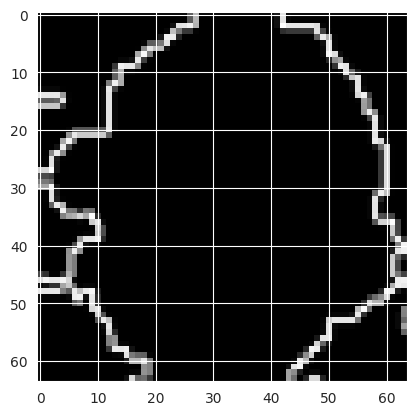

In [8]:
plt.imshow(parasitized_images[100], cmap='gray')

In [9]:
import numpy as np

# Check initial shapes and sizes
print(f"Parasitized images shape: {np.array(parasitized_images).shape}")
print(f"Uninfected images shape: {np.array(uninfected_images).shape}")

# Incremental concatenation
def incremental_concatenate(arrays, batch_size=100):
    result = []
    for i in range(0, len(arrays), batch_size):
        batch = arrays[i:i + batch_size]
        result.append(np.array(batch))

        print(f"Returning from: {i}")
    return np.concatenate(result)


# Incrementally concatenate images
parasitized_images_array = incremental_concatenate(parasitized_images)
uninfected_images_array = incremental_concatenate(uninfected_images)

X = np.concatenate((parasitized_images_array, uninfected_images_array))
y = np.array([1] * len(parasitized_images_array) + [0] * len(uninfected_images_array))

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Parasitized images shape: (2000, 64, 64)
Uninfected images shape: (2000, 64, 64)
Returning from: 0
Returning from: 100
Returning from: 200
Returning from: 300
Returning from: 400
Returning from: 500
Returning from: 600
Returning from: 700
Returning from: 800
Returning from: 900
Returning from: 1000
Returning from: 1100
Returning from: 1200
Returning from: 1300
Returning from: 1400
Returning from: 1500
Returning from: 1600
Returning from: 1700
Returning from: 1800
Returning from: 1900
Returning from: 0
Returning from: 100
Returning from: 200
Returning from: 300
Returning from: 400
Returning from: 500
Returning from: 600
Returning from: 700
Returning from: 800
Returning from: 900
Returning from: 1000
Returning from: 1100
Returning from: 1200
Returning from: 1300
Returning from: 1400
Returning from: 1500
Returning from: 1600
Returning from: 1700
Returning from: 1800
Returning from: 1900
Shape of X: (4000, 64, 64)
Shape of y: (4000,)


In [10]:
# Split data into training and testing sets (consider using scikit-learn's train_test_split)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (3200, 64, 64)
Shape of y_train: (3200,)


In [11]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [12]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

print(X_train_flat.shape)
print(X_test_flat.shape)

(3200, 4096)
(800, 4096)


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Treinamento de um modelo Random Forest
def train(X_train, y_train, n_estimators=50):
  _model = RandomForestClassifier(n_estimators=n_estimators)
  _model.fit(X_train, y_train.flatten())
  return _model

model = train(X_train_flat, y_train)
# before: 0.77

In [15]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Variáveis para armazenar o melhor modelo e a melhor métrica
best_model = None
best_accuracy = 0.0

def objective(trial):
    # Definir o espaço de busca para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 5, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 30)

    # Cria modelo
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "random_state": 42,
    }

    model = RandomForestClassifier(**params)

    model.fit(X_train_flat, y_train.flatten())  # Treina
    y_pred = model.predict(X_test_flat)  # Infere
    accuracy = accuracy_score(y_test, y_pred)  # Calcula métrica

    # Atualize o melhor modelo se necessário
    global best_model, best_accuracy
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy

    return accuracy

# Cria estudo a ser otimizado
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

# Imprime a evolução dos modelos ao final da otimização
print(f'Melhor solução:')
trial = study.best_trial

print(f'Valor: {trial.value}')
print(f'Parâmetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')
# Melhor solução:
# Valor: 0.6560232220609579
# Parâmetros:
# n_estimators: 169
# max_depth: 36
# min_samples_leaf: 7
# Melhor solução:
# Valor: 0.6325
# Parâmetros:
# n_estimators: 72
# max_depth: 28
# min_samples_leaf: 6

/home/teixeira/code/dataset-celulas-malaria/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-08-25 23:02:28,444] A new study created in memory with name: no-name-f032714f-8a10-4282-bacd-7e968cfba2d1
[I 2024-08-25 23:02:34,605] Trial 3 finished with value: 0.60625 and parameters: {'n_estimators': 81, 'max_depth': 23, 'min_samples_leaf': 15}. Best is trial 3 with value: 0.60625.
[I 2024-08-25 23:02:35,963] Trial 0 finished with value: 0.61 and parameters: {'n_estimators': 120, 'max_depth': 31, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.61.
[I 2024-08-25 23:02:36,359] Trial 2 finished with value: 0.5725 and parameters: {'n_estimators': 164, 'max_depth': 6, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.61.
[I 2024-08-25 23:02:41,707] Trial 6 finished with value: 0.61125 and

Melhor solução:
Valor: 0.6325
Parâmetros: 
    n_estimators: 72
    max_depth: 28
    min_samples_leaf: 6


Resultados de Teste
Acurácia: 0.61
F1 score: 0.6102854890478067


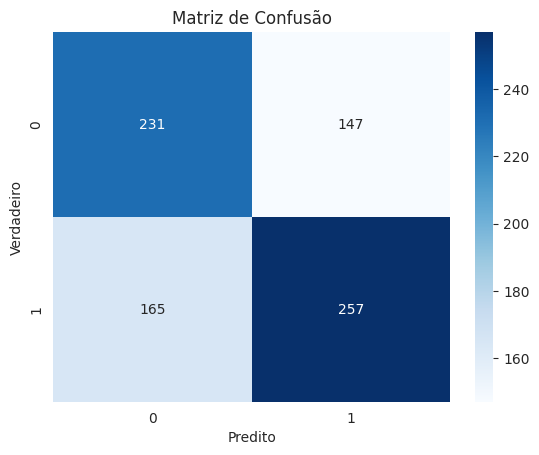

Resultados de Treino
Acurácia: 1.0
F1 score: 1.0


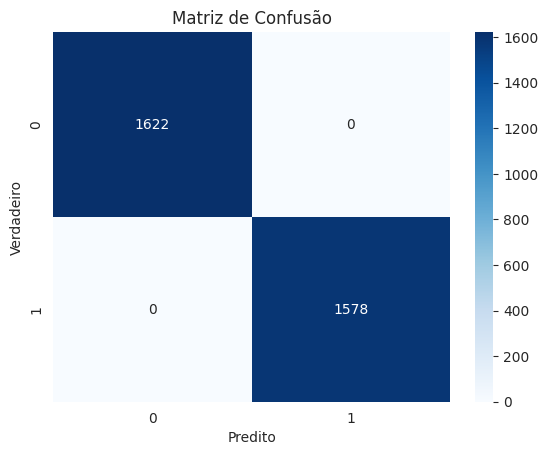

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

# Inferência e avaliação
def predict_and_evaluate(model, X_test, y_test, normalize=None):

  # Inferência
  y_pred = model.predict(X_test)

  # Métricas
  print('Acurácia:', accuracy_score(y_test, y_pred))
  print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

  # Matriz de confusão
  conf_matrix = confusion_matrix(y_test, y_pred, normalize=normalize)

  fmt = '.2f' if normalize == 'true' else 'd'
  sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Matriz de Confusão')
  plt.xlabel('Predito')
  plt.ylabel('Verdadeiro')
  plt.show()

print('Resultados de Teste')
predict_and_evaluate(model, X_test_flat, y_test)
print('Resultados de Treino')
predict_and_evaluate(model, X_train_flat, y_train)